In [27]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)
library(viridis)
#library(DESeq2)

In [16]:
#Create PS objects

biom <- import_biom("/gpfs/data/gilbert-lab/Lutz/Thyroid/PSfiles/thyroid_deblur.biom")
map <- import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Thyroid/PSfiles/natcss_thyroidmap.txt")
tree <- read_tree("/gpfs/data/gilbert-lab/Lutz/Thyroid/PSfiles/rep_phylo.tre")
thyroid_nt <- merge_phyloseq(biom,tree,map)
thyroid_nt <- prune_samples(sample_sums(thyroid_nt) > 1000, thyroid_nt)
thyroid <- merge_phyloseq(biom,tree,map) %>%
    prune_samples((sample_sums(.) > 1000), .) %>%
    filter_taxa(function(x) sum(x > 3) > (0.001*length(x)), TRUE) %>%
    transform_sample_counts(function(x) x / sum(x))

saveRDS(thyroid_nt, "/gpfs/data/gilbert-lab/Lutz/Thyroid/RDSfiles/thyroid_nt.rds")
saveRDS(thyroid, "/gpfs/data/gilbert-lab/Lutz/Thyroid/RDSfiles/thyroid.rds")
                                                      

Warning message in strsplit(msg, "\n"):
“input string 1 is invalid in this locale”

In [17]:
thyroid_nt

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 654 taxa and 180 samples ]
sample_data() Sample Data:       [ 180 samples by 133 sample variables ]
tax_table()   Taxonomy Table:    [ 654 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 654 tips and 652 internal nodes ]

In [38]:
thyroid.df = data.frame(sample_data(thyroid))
colnames(thyroid.df)

[1] "X.SampleID"               "BarcodeSequence"         
  [3] "LinkerPrimerSequence"     "ExtractionPlate"         
  [5] "PrimerPlate"              "Well"                    
  [7] "date"                     "birthdate_survey"        
  [9] "gender_survey"            "marital_status"          
 [11] "education_level"          "place_of_birth1"         
 [13] "place_of_birth2"          "place_of_birth3"         
 [15] "hispanic"                 "ethnicity___1"           
 [17] "ethnicity___2"            "ethnicity___3"           
 [19] "ethnicity___4"            "ethnicity___5"           
 [21] "ethnicity___6"            "ethnicity___7"           
 [23] "ethnicity___8"            "height"                  
 [25] "maximumweight"            "cigarettes1"             
 [27] "cigarettes_age"           "cigarettes_amt"          
 [29] "cigarettes_current"       "cigarettes_agequit"      
 [31] "fatigue"                  "appetite"                
 [33] "aches_pain"               "sleep"                   
 [35] "constipation"             "diarrhea"                
 [37] "menstrual_fertility"      "weight_gain"             
 [39] "weightloss"               "heat_cold"               
 [41] "skin_hair"                "drymouth"                
 [43] "voice"                    "coordination"            
 [45] "swelling_fluid_retention" "hair_changes"            
 [47] "memory_changes"           "bone"                    
 [49] "swallowing"               "dry_eyes"                
 [51] "numbness_or_pain"         "dental_problems"         
 [53] "nails"                    "visual_changes"          
 [55] "taste"                    "low_calcium"             
 [57] "incision"                 "bleeding"                
 [59] "side_effects_thyroid_med" "overall_health"          
 [61] "cope"                     "qol"                     
 [63] "happiness"                "in_control"              
 [65] "satisfying"               "remember"                
 [67] "useful"                   "appearance"              
 [69] "self_concept"             "diagnosis"               
 [71] "surgery"                  "treatment_completion"    
 [73] "rai"                      "wbs"                     
 [75] "thyroglobulin"            "thyroid_withdrawal"      
 [77] "anxiety"                  "depression"              
 [79] "diagnostic_tests"         "second_cancer"           
 [81] "cancer_recurrence"        "metastasis"              
 [83] "fearful_add_surg"         "family"                  
 [85] "support"                  "relationships"           
 [87] "sexuality"                "motivation"              
 [89] "time_work"                "productivity"            
 [91] "work_quality"             "loss_of_income"          
 [93] "loss_of_job"              "driving"                 
 [95] "chores"                   "meals"                   
 [97] "leisure"                  "isolation"               
 [99] "financial"                "religion"                
[101] "spiritual_activities"     "spiritual_life"          
[103] "uncertainty"              "positive_changes"        
[105] "purpose"                  "hopeful"                 
[107] "diagnosis_date"           "calc_diagnosis"          
[109] "type"                     "first_treatment"         
[111] "treatment_type"           "treatment_type___1"      
[113] "treatment_type___2"       "treatment_type___3"      
[115] "treatment_type___4"       "treatment_type___5"      
[117] "treatment_type___6"       "treatment_type___7"      
[119] "othertreatment"           "rai_doses"               
[121] "follow_up"                "stage"                   
[123] "speaking"                 "voicenormal"             
[125] "complication_2"           "physician"               
[127] "familymembers"            "surgeon"                 
[129] "raiphysician"             "income_survey"           
[131] "incomesupport_survey"     "lossofincome"            
[133] "Description"

In [19]:
#By Treatment Type
#treatments 6,7 have no representation
#many treatments are combined in individual patients

sample_tab = read.csv("/gpfs/data/gilbert-lab/Lutz/Thyroid/PSfiles/natcss_thyroidmap.csv")
colnames(sample_tab)[1] <- "SampleID"

obs = estimate_richness(na.omit(thyroid_nt), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

dfobs = merge(obs, sample_tab, on="SampleID")

ordobs = obs %>% group_by("treatment_type") %>%
    summarize(med.obs = median(Observed)) %>%
    arrange(desc(med.obs)) %>%
    magrittr::extract2("treatment_type")

stats.obs = dfobs %>%
    group_by(treatment_type) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) #%>%
    #arrange(-desc(mean))
stats.obs

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Observed~treatment_type, data=dfobs)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfobs$Observed, g=dfobs$treatment_type, method="bonferroni")
dunn

treatment_type,median,mean,sd,sem
No_tt,97.0,81.00000,39.50949,22.810816
tt_1,86.0,92.40000,32.01357,5.844852
tt_1_2,83.0,87.47328,27.24203,2.380147
tt_1_2_3,95.5,95.50000,17.67767,12.500000
tt_1_2_3_4,55.0,55.00000,NA,NA
tt_1_2_3_5,34.0,34.00000,NA,NA
tt_1_2_4,37.0,37.00000,NA,NA
tt_1_2_5,92.0,86.66667,40.26578,23.247461
tt_2,88.0,85.50000,20.44505,7.228416



	Kruskal-Wallis rank sum test

data:  Observed by treatment_type
Kruskal-Wallis chi-squared = 8.5549, df = 8, p-value = 0.3812


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 8.5549, df = 8, p-value = 0.38


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      No_tt       tt_1     tt_1_2   tt_1_2_3   tt_1_2_3   tt_1_2_3
---------+------------------------------------------------------------------
    tt_1 |  -0.295331
         |     1.0000
         |
  tt_1_2 |  -0.025302   0.810549
         |     1.0000     1.0000
         |
tt_1_2_3 |  -0.513407  -0.396883  -0.637067
         |     1.0000     1.0000     1.0000
         |
tt_1_2_3 |   1.152545   1.485128   1.340513   1.469302
         |     1.0000     1.0000     1.0000     1.0000
         |
tt_1_2_3 |   1.451764   1.825017   1.684709   1.751408   0.244310
         |     1.0000     1.0000     1.0000     1.0000     1.0000
         |
tt_1_2_4 |   1.401894   1.768369   1.627343   1.704390   0.203592  -

$chi2
[1] 8.554911

$Z
 [1] -0.29533187 -0.02530243  0.81054997 -0.51340780 -0.39688351 -0.63706737
 [7]  1.15254577  1.48512831  1.34051317  1.46930215  1.45176438  1.82501781
[13]  1.68470983  1.75140817  0.24431097  1.40189461  1.76836956  1.62734372
[19]  1.70439050  0.20359248 -0.04071850 -0.03918139  0.24249969 -0.02948465
[25]  0.47836290 -1.18025119 -1.47946981 -1.42960004 -0.05965885  0.34792458
[31] -0.07033312  0.54174348 -1.29281224 -1.61856020 -1.56426888 -0.01240432

$P
 [1] 0.38387019 0.48990687 0.20881208 0.30383304 0.34572668 0.26204048
 [7] 0.12454844 0.06875492 0.09003928 0.07087543 0.07328357 0.03399917
[13] 0.04602228 0.03993781 0.40349499 0.08047336 0.03849957 0.05183206
[19] 0.04415408 0.41933599 0.48376016 0.48437289 0.40419650 0.48823903
[25] 0.31619597 0.11895016 0.06950740 0.07641592 0.47621367 0.36394841
[31] 0.47196426 0.29399762 0.09803800 0.05277096 0.05887722 0.49505152

$P.adjusted
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

$comparisons
 [1] "No_tt - tt_1"            "No_tt - tt_1_2"         
 [3] "tt_1 - tt_1_2"           "No_tt - tt_1_2_3"       
 [5] "tt_1 - tt_1_2_3"         "tt_1_2 - tt_1_2_3"      
 [7] "No_tt - tt_1_2_3_4"      "tt_1 - tt_1_2_3_4"      
 [9] "tt_1_2 - tt_1_2_3_4"     "tt_1_2_3 - tt_1_2_3_4"  
[11] "No_tt - tt_1_2_3_5"      "tt_1 - tt_1_2_3_5"      
[13] "tt_1_2 - tt_1_2_3_5"     "tt_1_2_3 - tt_1_2_3_5"  
[15] "tt_1_2_3_4 - tt_1_2_3_5" "No_tt - tt_1_2_4"       
[17] "tt_1 - tt_1_2_4"         "tt_1_2 - tt_1_2_4"      
[19] "tt_1_2_3 - tt_1_2_4"     "tt_1_2_3_4 - tt_1_2_4"  
[21] "tt_1_2_3_5 - tt_1_2_4"   "No_tt - tt_1_2_5"       
[23] "tt_1 - tt_1_2_5"         "tt_1_2 - tt_1_2_5"      
[25] "tt_1_2_3 - tt_1_2_5"     "tt_1_2_3_4 - tt_1_2_5"  
[27] "tt_1_2_3_5 - tt_1_2_5"   "tt_1_2_4 - tt_1_2_5"    
[29] "No_tt - tt_2"            "tt_1 - tt_2"            
[31] "tt_1_2 - tt_2"           "tt_1_2_3 - tt_2"        
[33] "tt_1_2_3_4 - tt_2"       "tt_1_2_3_5 - tt_2"      
[35] "tt_1_2_4 - tt_2"         "tt_1_2_5 - tt_2"

In [39]:
# UNWEIGHTED UNIFRAC
thy.dist.unif = distance(thyroid, method = "unifrac", type = "samples")
#treatment type
thy.unif.nostrata.adtest = adonis2(thy.dist.unif ~ treatment_type, data=thyroid.df)
thy.unif.nostrata.adtest
#quality of life
thy.unif.nostrata.adtest = adonis2(thy.dist.unif ~ qol, data=thyroid.df)
thy.unif.nostrata.adtest
#rai (presumably radiation measure?)
thy.unif.nostrata.adtest = adonis2(thy.dist.unif ~ rai, data=thyroid.df)
thy.unif.nostrata.adtest

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGATTGTTAAGTCAGCGGTTAAAGGGTGTGGCTCAACCATGCATTGCCGTTGAAACTGGTGATCTTGAGTGCAGACAGGGATGCCGGAATTCGTGGT -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
treatment_type,8,0.7743331,0.0553178,1.251657,0.076
Residual,171,13.2235674,0.9446822,NA,NA
Total,179,13.9979005,1.0000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
qol,1,0.07654247,0.005468139,0.9786804,0.42
Residual,178,13.92135805,0.994531861,NA,NA
Total,179,13.99790052,1.000000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
rai,1,0.05223133,0.003731369,0.6666712,0.845
Residual,178,13.94566920,0.996268631,NA,NA
Total,179,13.99790052,1.000000000,NA,NA


In [40]:
# WEIGHTED UNIFRAC
thy.dist.wunif = distance(thyroid, method = "wunifrac", type = "samples")
#treatment type
thy.wunif.nostrata.adtest = adonis2(thy.dist.wunif ~ treatment_type, data=thyroid.df)
thy.wunif.nostrata.adtest
#quality of life
thy.wunif.nostrata.adtest = adonis2(thy.dist.wunif ~ qol, data=thyroid.df)
thy.wunif.nostrata.adtest
#rai (presumably radiation measure?)
thy.wunif.nostrata.adtest = adonis2(thy.dist.wunif ~ rai, data=thyroid.df)
thy.wunif.nostrata.adtest

Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGTAGGGTGCGAGCATTATCCGGAGTGACTGGGCGTAAAGAGTTGCGTAGGCGGTTTAATAAGTGAATAGTGAAACCTGGTGGCTCAACCATACAGACTATTATTCAAACTGTTAAACTCGAGAATGGTAGAGGTAACTGGAATTTCT -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
treatment_type,8,0.07202962,0.03175557,0.7010371,0.849
Residual,171,2.19622211,0.96824443,NA,NA
Total,179,2.26825173,1.00000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
qol,1,0.005820803,0.002566207,0.45796,0.784
Residual,178,2.262430932,0.997433793,NA,NA
Total,179,2.268251735,1.000000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
rai,1,0.01014091,0.004470805,0.7993772,0.509
Residual,178,2.25811082,0.995529195,NA,NA
Total,179,2.26825173,1.000000000,NA,NA


In [41]:
# BRAY CURTIS
thy.dist.bray = distance(thyroid, method = "bray", type = "samples")
#treatment type
thy.bray.nostrata.adtest = adonis2(thy.dist.bray ~ treatment_type, data=thyroid.df)
thy.bray.nostrata.adtest
#quality of life
thy.bray.nostrata.adtest = adonis2(thy.dist.bray ~ qol, data=thyroid.df)
thy.bray.nostrata.adtest
#rai (presumably radiation measure?)
thy.bray.nostrata.adtest = adonis2(thy.dist.bray ~ rai, data=thyroid.df)
thy.bray.nostrata.adtest

,Df,SumOfSqs,R2,F,Pr(>F)
treatment_type,8,1.228517,0.0425462,0.9498369,0.567
Residual,171,27.646368,0.9574538,NA,NA
Total,179,28.874885,1.0000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
qol,1,0.07340434,0.002542152,0.4536563,0.952
Residual,178,28.80148070,0.997457848,NA,NA
Total,179,28.87488504,1.000000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
rai,1,0.09371638,0.003245602,0.5795983,0.841
Residual,178,28.78116866,0.996754398,NA,NA
Total,179,28.87488504,1.000000000,NA,NA


Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTTTTGCAAGTTGAGAGTGGAAGCAGGGGGCTCAACCCCCTGACTGCTCCCAAAACTGTAGGACTTGAGTATGGGAGAGGCAGGCGGAATTCCTAG -- in the phylogenetic tree in the data you provided.”Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse


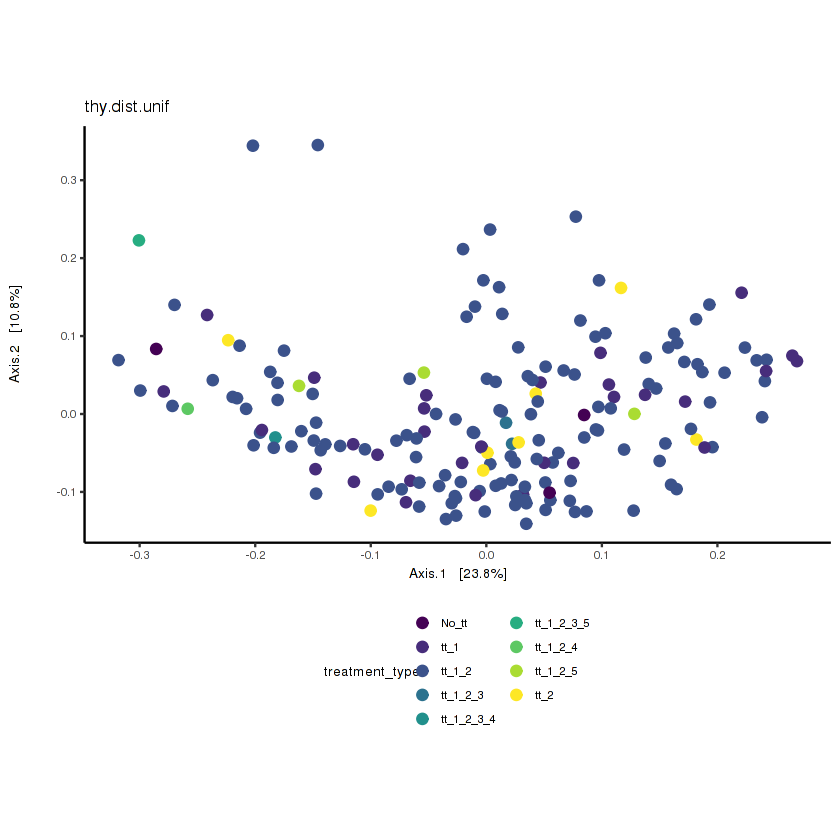

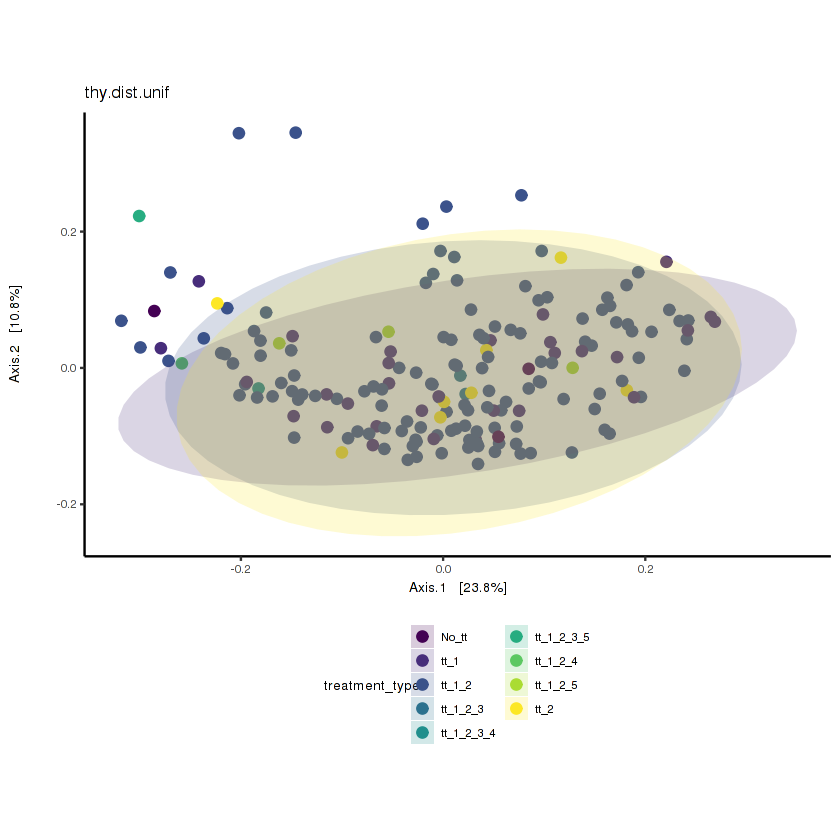

In [46]:
thy.dist.unif.log = ordinate(thyroid, method = "PCoA", distance = "unifrac")
thy.dist.unif.evals = thy.dist.unif.log$values$Eigenvalues
p = plot_ordination(thyroid, thy.dist.unif.log, color = "treatment_type") + 
    ggtitle("thy.dist.unif") + 
    geom_point(size=2.5) +#, alpha=0.4) + 
    scale_colour_viridis(option="viridis", discrete=TRUE, direction=1) +
    #stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = treatment_type), linetype=0) +
    #scale_fill_viridis(option="viridis", discrete=TRUE, direction=1)+
    coord_fixed(sqrt(thy.dist.unif.evals[2] / thy.dist.unif.evals[1]))

p = p + guides(colour = guide_legend(title = "treatment_type", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_classic() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              legend.position = "bottom")

p

p2 = p + stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = treatment_type), linetype=0) +
    scale_fill_viridis(option="viridis", discrete=TRUE, direction=1)
  
p2